#Importations

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import random as rd
import numpy as np
import os

#Data Preparation

La présente dataset est sous formes de titres d'actualité tirés de différents sites web média, dont la BBC, Reuters et Al Jazeera..

In [7]:
df=pd.read_csv('news.csv')

#Utils

In [8]:
# Convert a title into a list of words (stemming and lemmatization are optional)
def text2list(text,stopword,lower=True,lemma=False,stemma=False):

    text_clean=text if lower==False else text.lower()

    #tokenize and remove stop words
    token=[i for i in nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(text_clean) if i not in stopword]

    #lemmatization
    if lemma:
        text_processed=[nltk.stem.wordnet.WordNetLemmatizer().lemmatize(i) for i in token]
    else:
        text_processed=token

    #stemming
    if stemma:
        output=[nltk.stem.PorterStemmer().stem(i) for i in text_processed]
    else:
        output=text_processed

    #remove numbers as they are stopword as well
    for i in [ii for ii in output]:
        try:
            float(i)
            output.remove(i)
        except:
            pass

    return [i for i in output if i not in stopword]

In [9]:
# Compute the common number of words between 2 titles (edge of the graph) and ignoring stopwords
def find_common(text1,text2,stopword):

    common=set(text1).intersection(set(text2)).difference(set(stopword))

    return len(common)

In [10]:
# Add new column 'word' as list of words (extracted from the title)
def add_wordlist(df,stopword,**kwargs):

    temp=[]
    for i in df['title']:
        temp.append(text2list(i,stopword,lower=True,**kwargs))
    df['word']=temp

    return df

In [12]:
# Stopwords construction
import nltk
nltk.download('stopwords')

stopword=stopwords.words('english')+['algeria',
 'algerian',
 'arabia',
 'arabian',
 'around',
 'b',
 'back',
 'bahrain',
 'beyond',
 'c',
 'e',
 'egyptian',
 'emirates',
 'f',
 'first',
 'g',
 'h',
 'iran',
 'iranian',
 'iranians',
 'iraq',
 'israel',
 'israeli',
 'j',
 'jerusalem',
 'jordan',
 'k',
 'kuwait',
 'l',
 'lebanon',
 'lebanonese',
 'moroccan',
 'morocco',
 'n',
 'oman',
 'p',
 'pakistan',
 'palestinian',
 'palestinians',
 'q',
 'qatar',
 'qatari',
 'r',
 'russia',
 'russian',
 'saudi',
 'syria',
 'syrian',
 'tunisia',
 'tunisian',
 'turkey',
 'turkish',
 'u',
 'us',
 'v',
 'w',
 'within',
 'would',
 'x',
 'yemen',
 'yemeni',
 'z']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
# Create dual axis plot
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
                    sec_color='b',fig_size=(10,5),
                   x_label='',y_label1='',y_label2='',
                   legend1='',legend2='',grid=False,title=''):

    #preset the figure
    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)

    #plot left hand side
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15
    plt.legend(loc=3)


    #both curves share x axis
    ax2=ax.twinx()

    #plot right hand side
    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15
    plt.legend(loc=4)

    #enfin
    fig.tight_layout()
    plt.grid(grid)
    plt.title(title)
    plt.show()

In [22]:
# Compute perpendicular distance
def get_distance(x,y,a,b):

    temp1=y-x*a-b
    temp2=(a**2+1)**0.5

    return np.abs(temp1/temp2)

In [23]:
# Estimate parameters of linear equation
def get_line_params(x1,y1,x2,y2):

    a=(y1-y2)/(x1-x2)
    b=y1-a*x1

    return a,b

#Graph Construction

L'index du titre de l'actualité  serait présenté comme le sommet. Le nombre de mots communs serait indiqué comme le poids de l'arête. Certains titres peuvent n'avoir aucun mot en commun avec les autres.

In [15]:
# Construct Graph as follows: vertices are titles indices and edges are the number of common words between titles (if ≠ 0)
def build_graph(df,stopword):

    graph=nx.Graph()

    for i in range(len(df)):
        for j in range(i+1,len(df)):
            w=find_common(df['word'][i],df['word'][j],stopword)
            if w!=0:
                graph.add_edge(i,j,weight=w)

    return graph

In [16]:
#Graph structure plotting
def plot_graph(graph,position,nodecolor=[],nodesize=[],
               nodecmap=plt.cm.copper,title=None,colorbartitle=None,
               plot_colorbar=False,**kwargs):

    if not nodecolor:
        nodecolor=[0]*len(graph)
    if not nodesize:
        nodesize=300

    ax=plt.figure(figsize=(20,10)).add_subplot(111)

    nx.draw(graph,node_size=nodesize,pos=position,
            node_color=nodecolor,cmap=nodecmap,**kwargs)

    #remove axes
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #plot colorbar for node color
    if plot_colorbar:
        sm=plt.cm.ScalarMappable(cmap=nodecmap,
                                 norm=plt.Normalize(vmin=min(nodecolor),
                                                    vmax=max(nodecolor)))
        sm._A=[]
        cb=plt.colorbar(sm,ticks=[min(nodecolor),max(nodecolor)])
        cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=11)
        cb.ax.set_ylabel(colorbartitle,fontsize=11,rotation=270)

    plt.xticks([])
    plt.yticks([])
    plt.title(title,fontsize=15)
    plt.show()

Pour certains titres, il se peut qu'il n'y ait pas de mots communs avec d'autres. En d'autres termes, ils ne sont pas inclus dans le graphe. Nous devons tout de même les ajouter à la liste, nous ne pouvons pas laisser cette minorité de côté. Même s'il ne s'agit pas d'informations clés publiées par tous les sites web, il peut toujours s'agir d'informations exclusives.

In [17]:
# Add isolated vertices to the graph structure
def add_non_connected(df,output,graph):

    for i in range(len(df)):
        if i not in list(graph.nodes):
            output.append(i)

    return output

#Similar Content Removal

##graph traversal approach

Si l'une des nouvelles est suffisamment importante, elle doit avoir été couverte par pratiquement toutes les sources. Tous les titres faisant référence à cette histoire doivent avoir des mots en commun. Traduit en théorie des graphes, chaque histoire est susceptible de former une clique maximale. Néanmoins, la clique maximale exige que tous les sommets soient connectés les uns aux autres. En réalité, la plupart des cliques maximales que nous pouvons obtenir sont de l'ordre de 2 ou 3, ce qui nous oblige à faire un compromis. Nous nous intéressons maintenant aux sommets dont le degré est anormalement élevé. Cela veut dire que le sommet vital doit être connecté à tous les autres sommets à l'intérieur d'un sous-ensemble. Chaque sous-ensemble indique une histoire unique. Tous les sommets adjacents au sommet vital devraient être redondants puisqu'ils se réfèrent à la même histoire. Le degré n'est pas la seule mesure valable sur laquelle nous pouvons nous appuyer. D'autres mesures telles que la centralité de proximité et la centralité de vecteur propre sont des options disponibles tant que nous pouvons étayer nos hypothèses par une histoire raisonnable.

L'algorithme de traversée de graphe est le suivant:


1. Créer un dictionnaire ordonné où le sommet est la clé et le degré est la valeur.

2. À chaque itération, retirer le sommet V ayant le degré le plus élevé du dictionnaire ordonné actuel.

3. Ajouter le sommet V à l'ensemble des résultats

4. Retirer tous les voisins du sommet V du dictionnaire ordonné actuel.

5. Répéter les étapes 2 à 4 jusqu'à ce que le dictionnaire ordonné soit vide.



In [18]:
# Graph Traversal algorithm
def algo(graph):

    #dictionary of all nodes and degrees in graph
    D=dict(graph.degree)

    #order dict by each node's degree
    D=dict(sorted(D.items(),key=lambda x:x[1],reverse=False))

    queue=list(D.keys())
    result=[]

    #in each iteration, find the node with the highest agree in the queue
    #remove the node's neighbors in the queue until the queue is empty
    while queue:

        V=queue.pop()
        result.append(V)

        redundant=set(queue).intersection(set(graph.neighbors(V)))

        for i in redundant:
            queue.remove(i)

    return result

In [19]:
# Using graph traversal algorithm to removes similar content (similar titles from different media sources)
def remove_similar(df,stopword,plot_original=False,
                    plot_result=False,**kwargs):

    #tokenization
    df=add_wordlist(df,stopword,**kwargs)

    #graph building
    graph=build_graph(df,stopword,**kwargs)

    #fix node position for visual comparison
    pos=nx.spring_layout(graph,k=0.3)

    #plot original
    if plot_original:
        plot_graph(graph,position=pos,
                   title='Original',**kwargs)

    #traversal
    result=algo(graph)

    #plot result, highlight the result
    if plot_result:
        nodecolor=[]
        for i in graph.nodes:
            if i in result:
                nodecolor.append(1)
            else:
                nodecolor.append(0)

        nodesize=[]
        for i in graph.nodes:
            if i in result:
                nodesize.append(700)
            else:
                nodesize.append(300)

        plot_graph(graph,position=pos,nodecolor=nodecolor,
                   nodesize=nodesize,title='Graph Theory Result',**kwargs)

    #exclusive content may share no common words with others
    #we still need the last puzzle to get the output
    output=add_non_connected(df,result,graph)

    #return the selected nodes in a dataframe format
    data=df.loc[[i for i in set(output)]]
    data.reset_index(inplace=True,drop=True)
    del data['word']

    return data,pos

Le résultat s'avère être une grande réussite. L'algorithme capture gracieusement tous les sommets essentiels. Tous les sommets de couleur claire sont sélectionnés. Tous les sommets de couleur foncée sont supprimés.

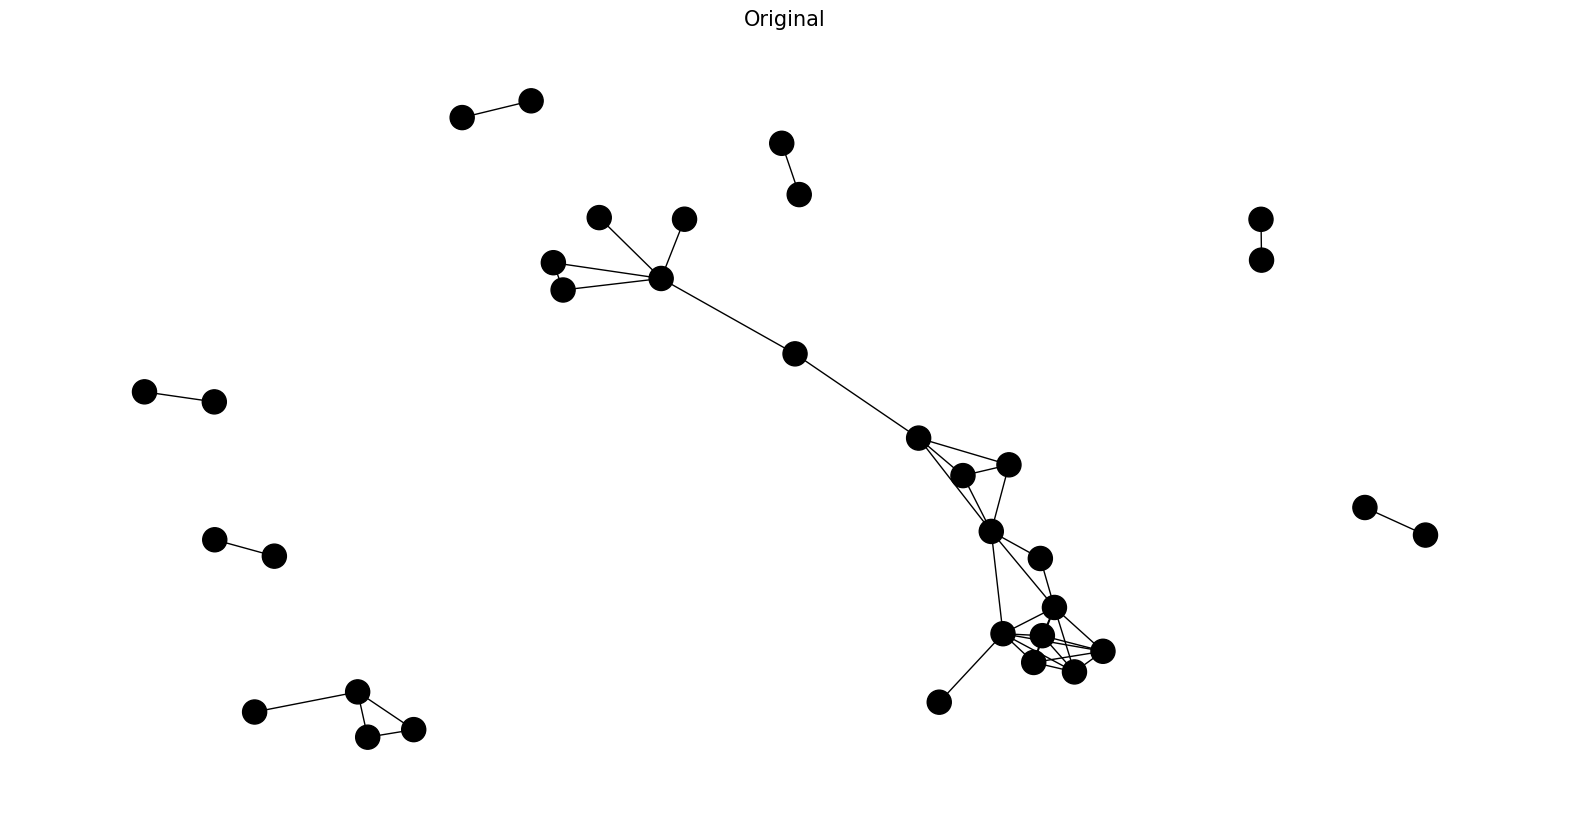

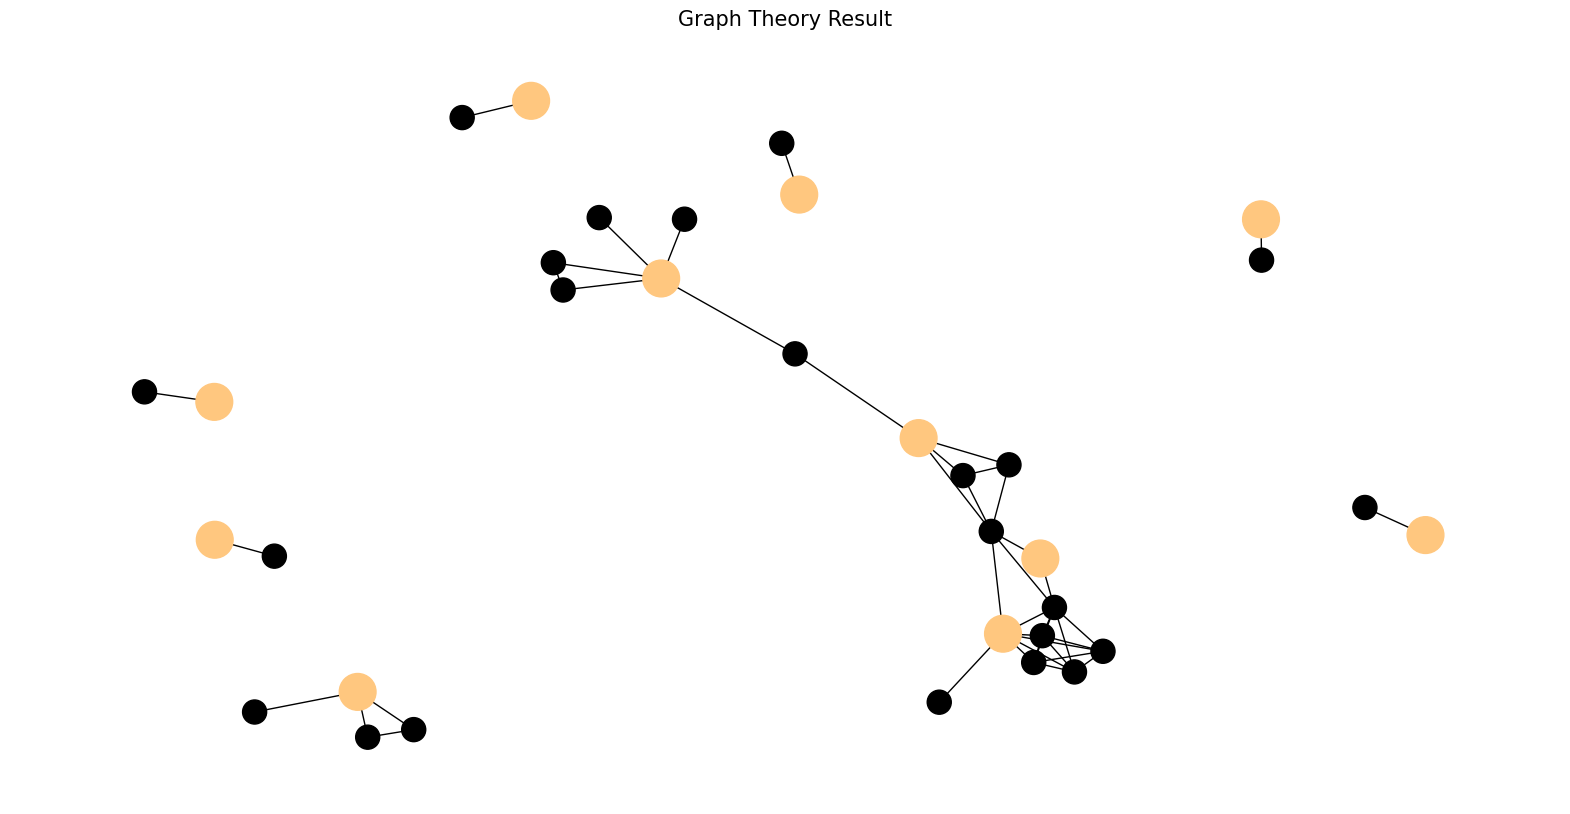

In [20]:
#Visualize the algorithm results
output,position=remove_similar(df,stopword,plot_original=True,plot_result=True)

##unsupervised ML

Dans cette partie, on modèlise notre problématique par un clustering non supervisé de documents textuels.

###DBSCAN

DBSCAN permet une classification à la fois linéaire et non linéaire. Il peut détecter automatiquement le nombre de grappes, mais il nécessite un réglage minutieux de son paramètre de distance interne, epsilon.

In [24]:
def dbscan_algo(df,stopword):

    #convert text to feature vectors
    df['clean']=[' '.join(
        text2list(i,stopword,lower=True)) for i in df['title']]
    train=CountVectorizer()
    train_matrix=train.fit_transform(df['clean'])

    #set minimum sample of dbscan at 2
    #as we have observed in the graph theory
    #the minimum order of a connected component is 2
    #traditionally knn should take minimum sample-1
    #but 1nn doesnt work in reality, thus, we use 2nn
    clf=NearestNeighbors(n_neighbors=2)
    clf.fit(train_matrix)

    #prepare for visualization
    distances,_=clf.kneighbors(train_matrix)
    distances=sorted(distances.tolist(),key=lambda x:x[1])
    distances=[i[1] for i in distances]

    #viz and get eps
    optimal=find_optimal_eps(distances)

    #dbscan
    #minimum sample is determined by the worst case scenario
    #when minimum sample is at 2
    #the algorithm is equivalent to single link hierarchical clustering
    #which is commonly used in nlp problems
    clf=DBSCAN(eps=optimal,min_samples=2)
    clf.fit(train_matrix)

    return clf.labels_

Nous cherchons une méthode conventionnelle pour déterminer l'epsilon idéal, KNN. En utilisant la méthode 'knee', epsilon optimal devrait se produire avant la plus grande augmentation de la distance 2-NN. Par tradition, la sélection de K devrait être l'échantillon minimum moins un.

In [25]:
#Using knee method for knn to find the optimal epsilon
def find_optimal_eps(distances):

    #compute perpendicular distance
    a,b=get_line_params(0,distances[0],len(distances)-1,distances[-1])

    distance=[]
    for i in range(len(distances)):
        distance.append(get_distance(i,distances[i],a,b))

    #viz
    dual_axis_plot(np.arange(1,len(distance)+1),distances,distance,
                   x_label='Points Sampled by Distance',
                   y_label1='2-NN Distance',
                   y_label2='Perpendicular Distance',
                   legend1='2-NN',legend2='Knee',
                   title='Knee Method for KNN',
                   fst_color='#0abda0',sec_color='#720017')

    #get optimal eps
    optimal=distances[distance.index(max(distance))]

    return optimal

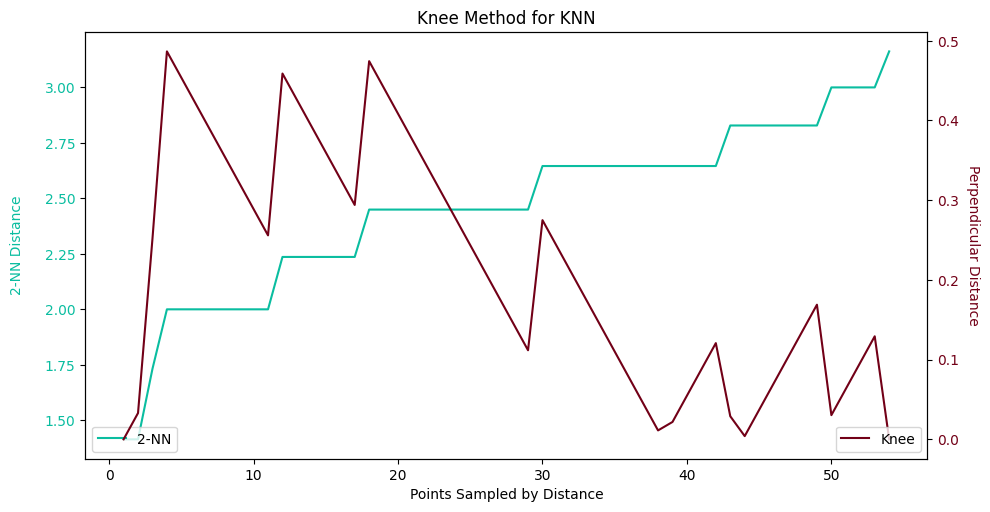

In [26]:
df['class']=dbscan_algo(df,stopword)

In [27]:
#build graph
df=add_wordlist(df,stopword)
graph=build_graph(df,stopword)

Nous visualisons ici les résultats de l'apprentissage non supervisé dans le même graphe. Trois labels différents sont représentées par des sommets de couleurs différentes. La théorie des graphes et la lecture des titres ne permettent guère de trouver un modèle au sein d'un même groupe. Le résultat est interprétable

<ipython-input-16-74e3709b2eb0>:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb=plt.colorbar(sm,ticks=[min(nodecolor),max(nodecolor)])


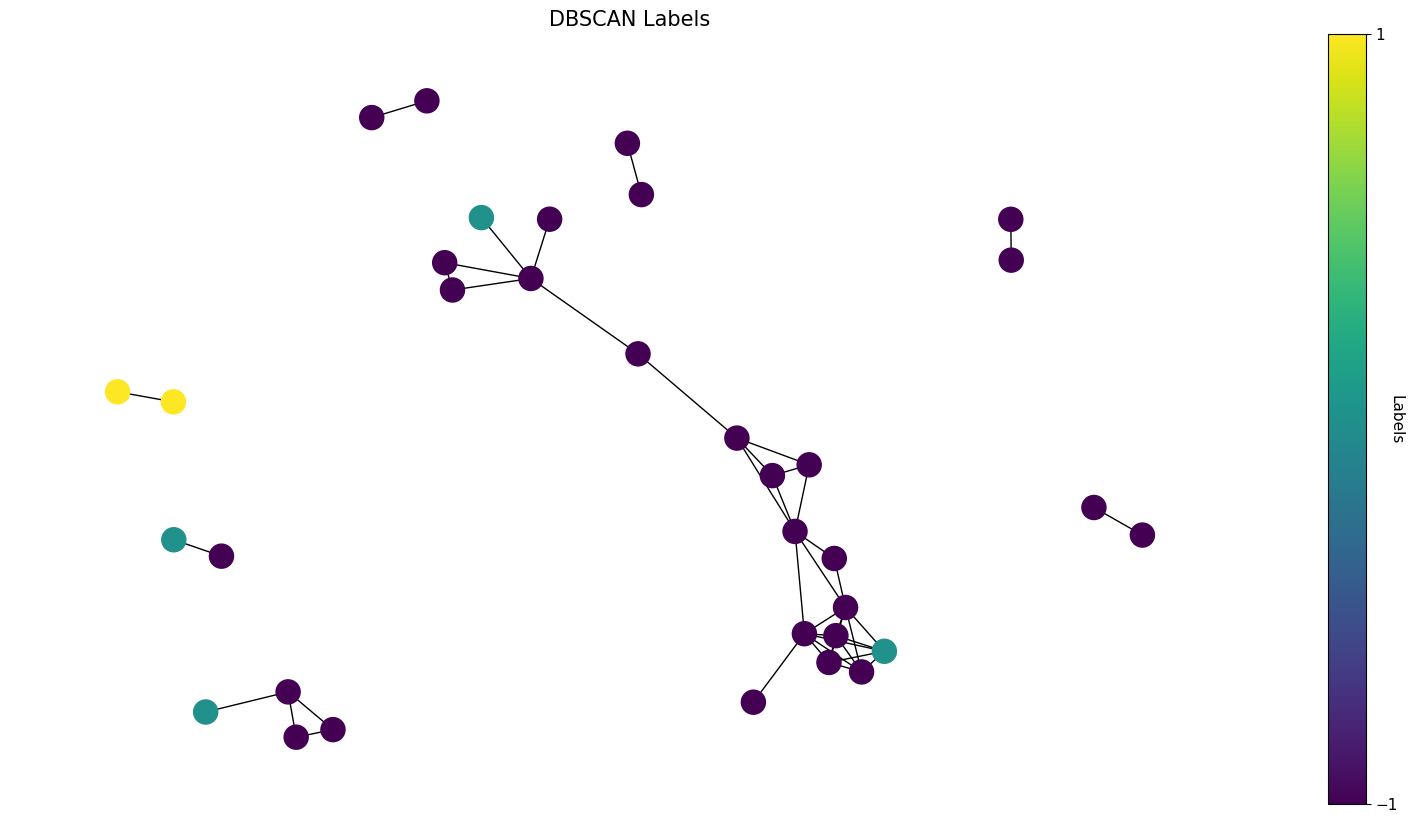

In [28]:
nodecolor=[df.at[i,'class'] for i in graph.nodes]

plot_graph(graph,nodecolor=nodecolor,
           position=position,nodecmap=plt.cm.viridis,
           title='DBSCAN Labels',plot_colorbar=True,
           colorbartitle='Labels')

Le résultat de DBSCAN est décevant. Il n'y a que 3 labels différents. Si nous examinons rapidement les données textuelles, nous pourrions certainement identifier plus de trois histoires importantes. Ce résultat frustrant ne nous a pas laissé d'autre choix que de choisir un algorithme d'apprentissage non supervisé naïf, K-means.

###K-means

In [29]:
def kmeans_algo(df,stopword,maxk=50,**kwargs):

    #convert text to feature vectors
    df['clean']=[' '.join(
        text2list(i,stopword,lower=True)) for i in df['title']]
    train=CountVectorizer()
    train_matrix=train.fit_transform(df['clean'])

    #viz and get k
    optimal=get_optimal_k(train_matrix,maxk=maxk,**kwargs)

    #kmeans
    clf=KMeans(optimal)
    clf.fit(train_matrix)

    return clf.labels_

Afin de déterminer le nombre de clusters optimal, on utilise la méthode 'elbow'.

In [30]:
#Using elbow method for kmeans to find the optimal k
def get_optimal_k(train_matrix,maxk=50,plot_elbow=False):

    #compute inertia
    sse=[]
    for i in range(1,maxk):
        clf=KMeans(n_clusters=i)
        clf.fit(train_matrix)
        sse.append(clf.inertia_/10000)

    #elbow method for kmeans
    a,b=get_line_params(0,sse[0],len(sse)-1,sse[-1])

    distance=[]
    for i in range(len(sse)):
        distance.append(get_distance(i,sse[i],a,b))

    #viz
    if plot_elbow:
        dual_axis_plot(np.arange(1,len(distance)+1),sse,distance,
                       x_label='Numbers of Cluster',
                       y_label1='Sum of Squared Error',
                       y_label2='Perpendicular Distance',
                       legend1='SSE',legend2='Distance',
                       title='Elbow Method for K Means',
                       fst_color='#116466',sec_color='#e85a4f')

    #get optimal k
    optimal=distance.index(max(distance))

    return optimal

In [32]:
# Removing similar content with unsupervised learning
def remove_similar_unsupervised(df,stopword,**kwargs):

    #the worst case of a clustering problem is n//2 clusters
    #where n is the number of data points
    #hence, we set maxk to len(df)//2+1
    df['class']=kmeans_algo(df,stopword,maxk=len(df)//2+1,**kwargs)

    #within each label, its the same story written by different reporters
    #so we randomly select one as our final output
    result=[]
    for i in set(df['class']):
        cluster=df[df['class']==i].index.tolist()
        result.append(rd.choice(cluster))

    data=df.loc[result]
    data.reset_index(inplace=True,drop=True)
    del data['clean']

    return data,result

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


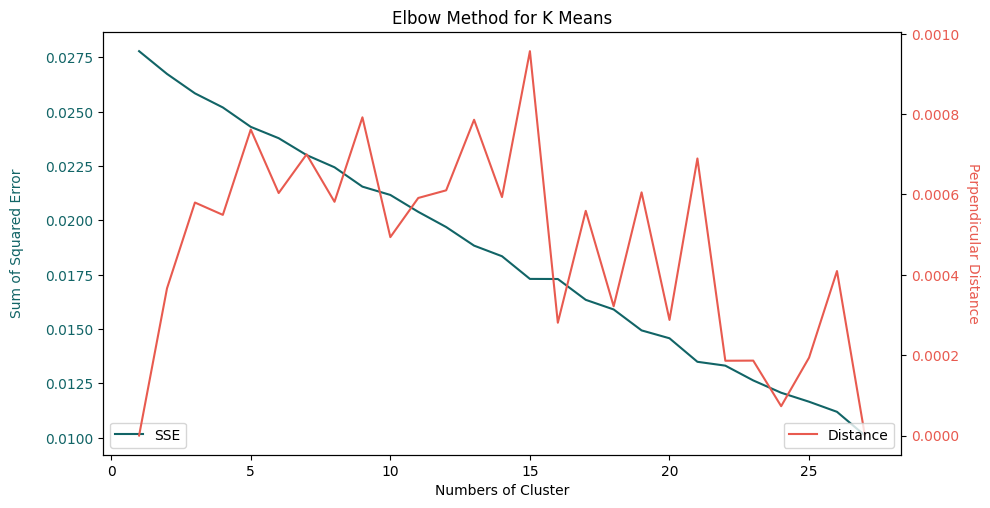

In [33]:
data,result=remove_similar_unsupervised(df,stopword,plot_elbow=True)


K-means constitue une excellente solution à notre problème d'exploration de texte. Il reconnaît certains des composants fortement connectés à l'intérieur d'une structure de graphe. Cependant, il semble toujours obsolète par rapport aux performances de la théorie des graphes. Certains composants faiblement connectés sont mal classés.

<ipython-input-16-74e3709b2eb0>:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb=plt.colorbar(sm,ticks=[min(nodecolor),max(nodecolor)])


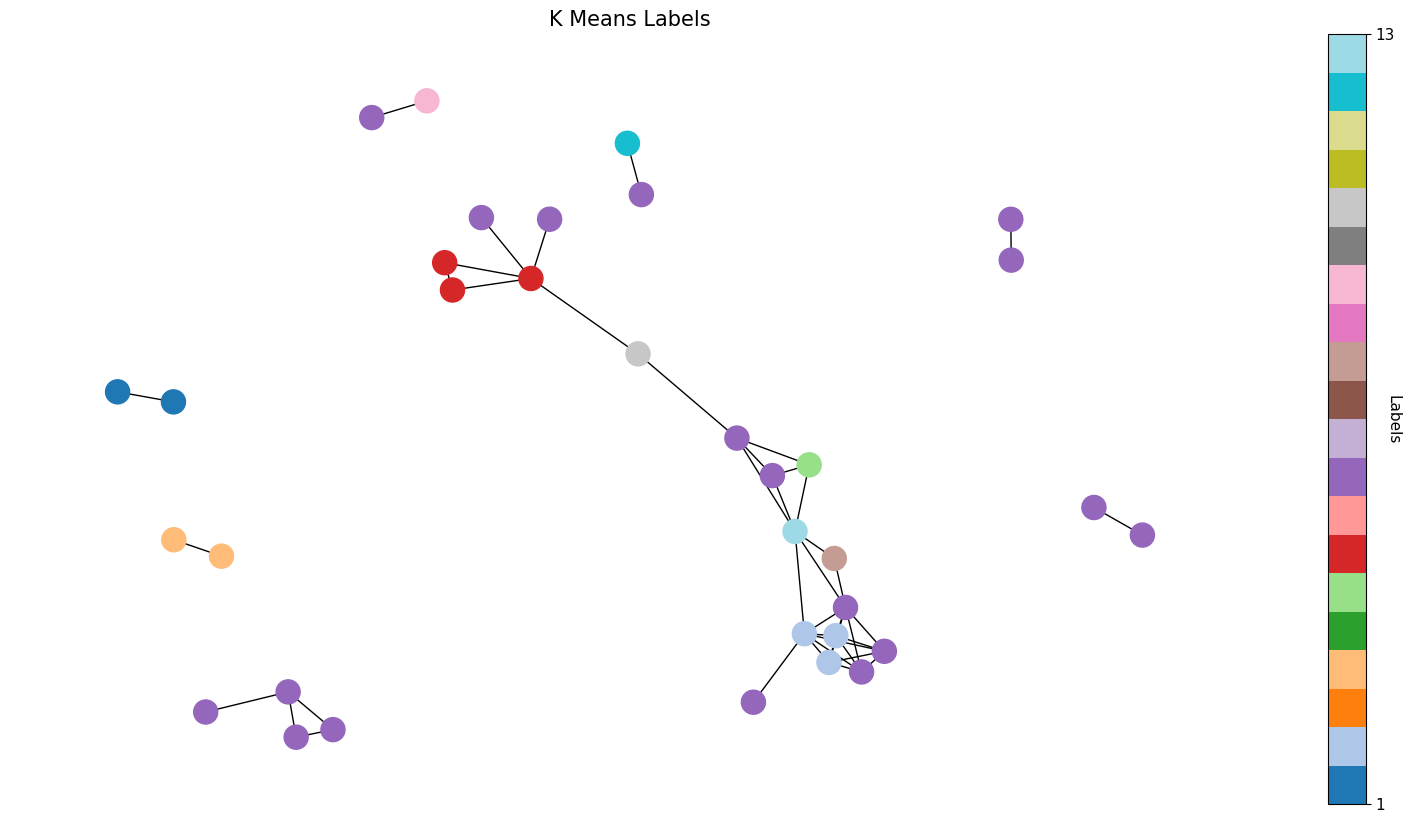

In [34]:
nodecolor=[df.at[i,'class'] for i in graph.nodes]

plot_graph(graph,nodecolor=nodecolor,position=position,nodecmap=plt.cm.tab20,
           title='K Means Labels',plot_colorbar=True,colorbartitle='Labels')

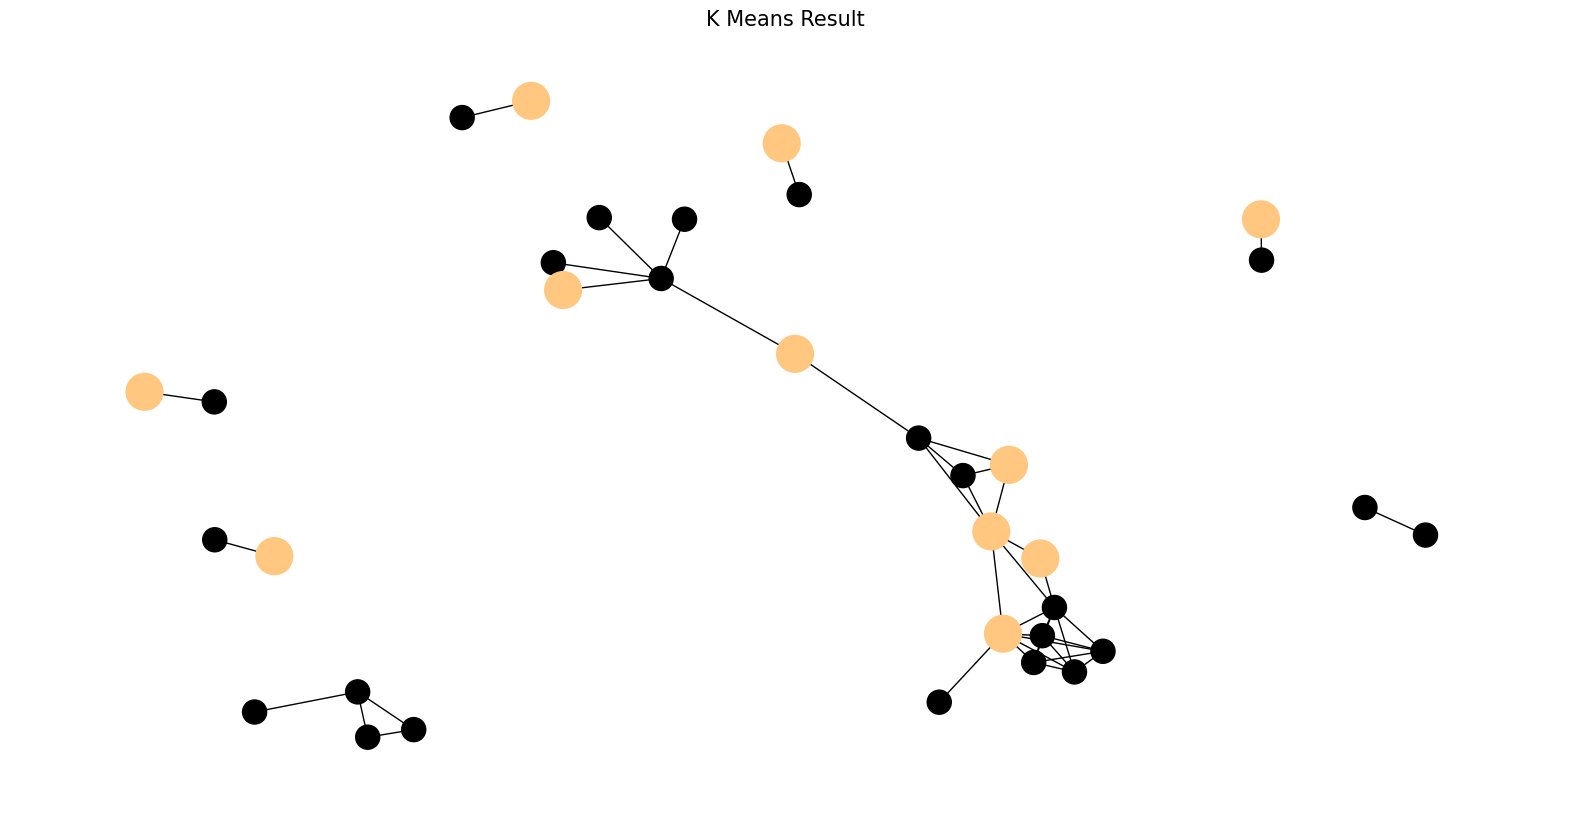

In [35]:
nodecolor=[]
for i in graph.nodes:
    if i in result:
        nodecolor.append(1)
    else:
        nodecolor.append(0)

nodesize=[]
for i in graph.nodes:
    if i in result:
        nodesize.append(700)
    else:
        nodesize.append(300)

plot_graph(graph,nodecolor=nodecolor,position=position,
           nodesize=nodesize,title='K Means Result')

#Conclusion

En résumé, la théorie des graphes émerge comme une approche plus efficace pour notre problématique de recherche d'informations. La sous-estimation généralisée de la théorie des graphes, en dépit de la prédominance de la publicité autour de l'apprentissage automatique, souligne l'importance de considérer différentes perspectives et méthodologies dans le domaine de la recherche d'informations.